In [13]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cm
from sklearn.decomposition import PCA

In [14]:
import salishsea_tools.river_202108 as rivers

In [15]:
physics_202111 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_day_avg_physics_20190101_20191231.nc')

In [31]:
river_call = 'SnohomishAllenQuilceda'
year = '2019'
river_idx = [rivers.prop_dict['skagit'][river_call]['i'], rivers.prop_dict['skagit'][river_call]['j']]
river_range = [river_idx[0] - 15, river_idx[0] + 15, river_idx[1] - 15, river_idx[1] + 15]

In [32]:
phys_arr_full = physics_202111.vosaline.to_numpy()

In [33]:
phys_arr = phys_arr_full[:,:,river_range[0]:river_range[1], river_range[2]:river_range[3]]

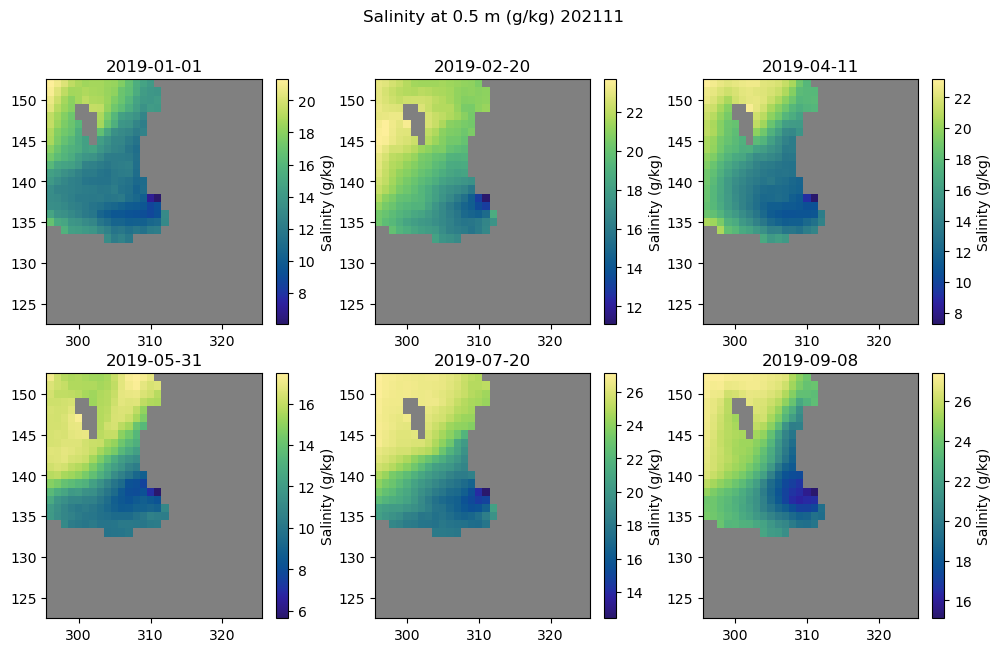

In [34]:
# make the indicies for plotting six sample salinity fields
plot_ind = np.array([[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]])
plot_day = np.array([0, 50, 100, 150, 200, 250])  # this selects what days of each year to plot, change for > 1 year

# open the mesh mask and use it to mask the land
# mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask201702.nc')
mesh = xr.open_dataset('../../../../MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask_full = 1 - mesh.tmask[0]
tmask = tmask_full[0][river_range[0]:river_range[1], river_range[2]:river_range[3]]

kd = 0 ## this will stay for surface
imin = river_range[0]
imax = river_range[1]
jmin = river_range[2]
jmax = river_range[3]

fig1, ax1 = plt.subplots(2, 3, figsize=(12, 7))

## SHOWS SALINITY PLOTS
for i in np.arange(0,6):
    
    cmap = cm.haline
    cmap.set_bad('gray')


    day = plot_day[i]
    day_str = np.datetime_as_string(physics_202111.time[day].values, unit='D')

    myarray = np.ma.array(phys_arr[day, kd, :, :])

    salinity = np.ma.masked_array(myarray, mask=tmask)
    colours = ax1[plot_ind[i][0], plot_ind[i][1]].pcolormesh(np.arange(jmin, jmax), np.arange(imin, imax), salinity, cmap=cm.haline, shading='auto')
    ax1[plot_ind[i][0], plot_ind[i][1]].set_title(day_str)


    cb = fig1.colorbar(colours, ax=ax1[plot_ind[i][0], plot_ind[i][1]])
    cb.set_label('Salinity (g/kg)')
    viz_tools.set_aspect(ax1[plot_ind[i][0], plot_ind[i][1]]);
    
    
fig1.suptitle(f'Salinity at {kd+0.5} m (g/kg) ' + '202111')

plt.savefig('sal_field_' + river_call + '_' + year + '.png')

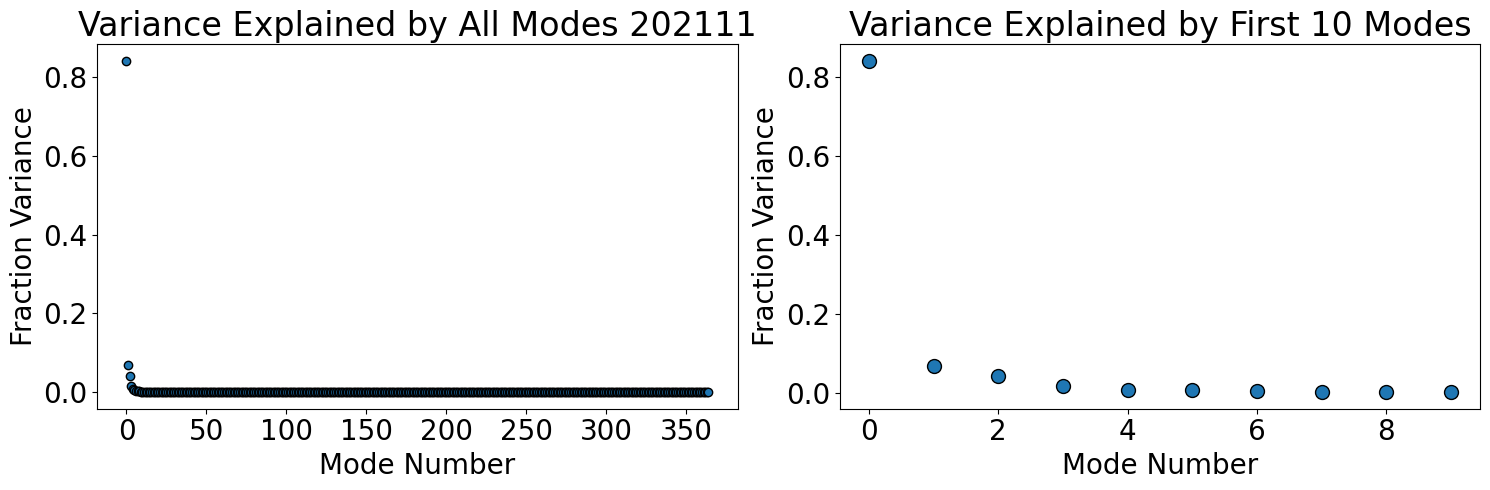

In [35]:
# define dimensions for later reshaping
num_days = phys_arr.shape[0]

Ny = phys_arr.shape[2]
Nx = phys_arr.shape[3]

## DO PCA PART
surface = phys_arr[:,0,:,:].reshape(num_days, 900)  # TODO: FIX THIS to not hard coded
surface = np.nan_to_num(surface)

# does the PCA part
n_modes = np.min(np.shape(surface))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(surface)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

#plot fraction of variance explained by each mode
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = 20)
plt.ylabel('Fraction Variance', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Variance Explained by All Modes ' + '202111', fontsize = 24)

plt.subplot(1,2,2)
n_modes_show = 10  # TODO change this to fun input
plt.scatter(range(n_modes_show),fracVar[:n_modes_show], s = 100, edgecolor = 'k')
plt.xlabel('Mode Number', fontsize = 20)
plt.ylabel('Fraction Variance', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes', fontsize = 24)

plt.tight_layout()

# if saveIt:
#     plt.savefig('tutorial4_fig3.png')

plt.show()

In [36]:
## access the PCA results
fracVar = pca.explained_variance_ratio_
eigvecs = pca.components_
PCs = pca.fit_transform(surface)
max_pc = PCs[:,0].max()

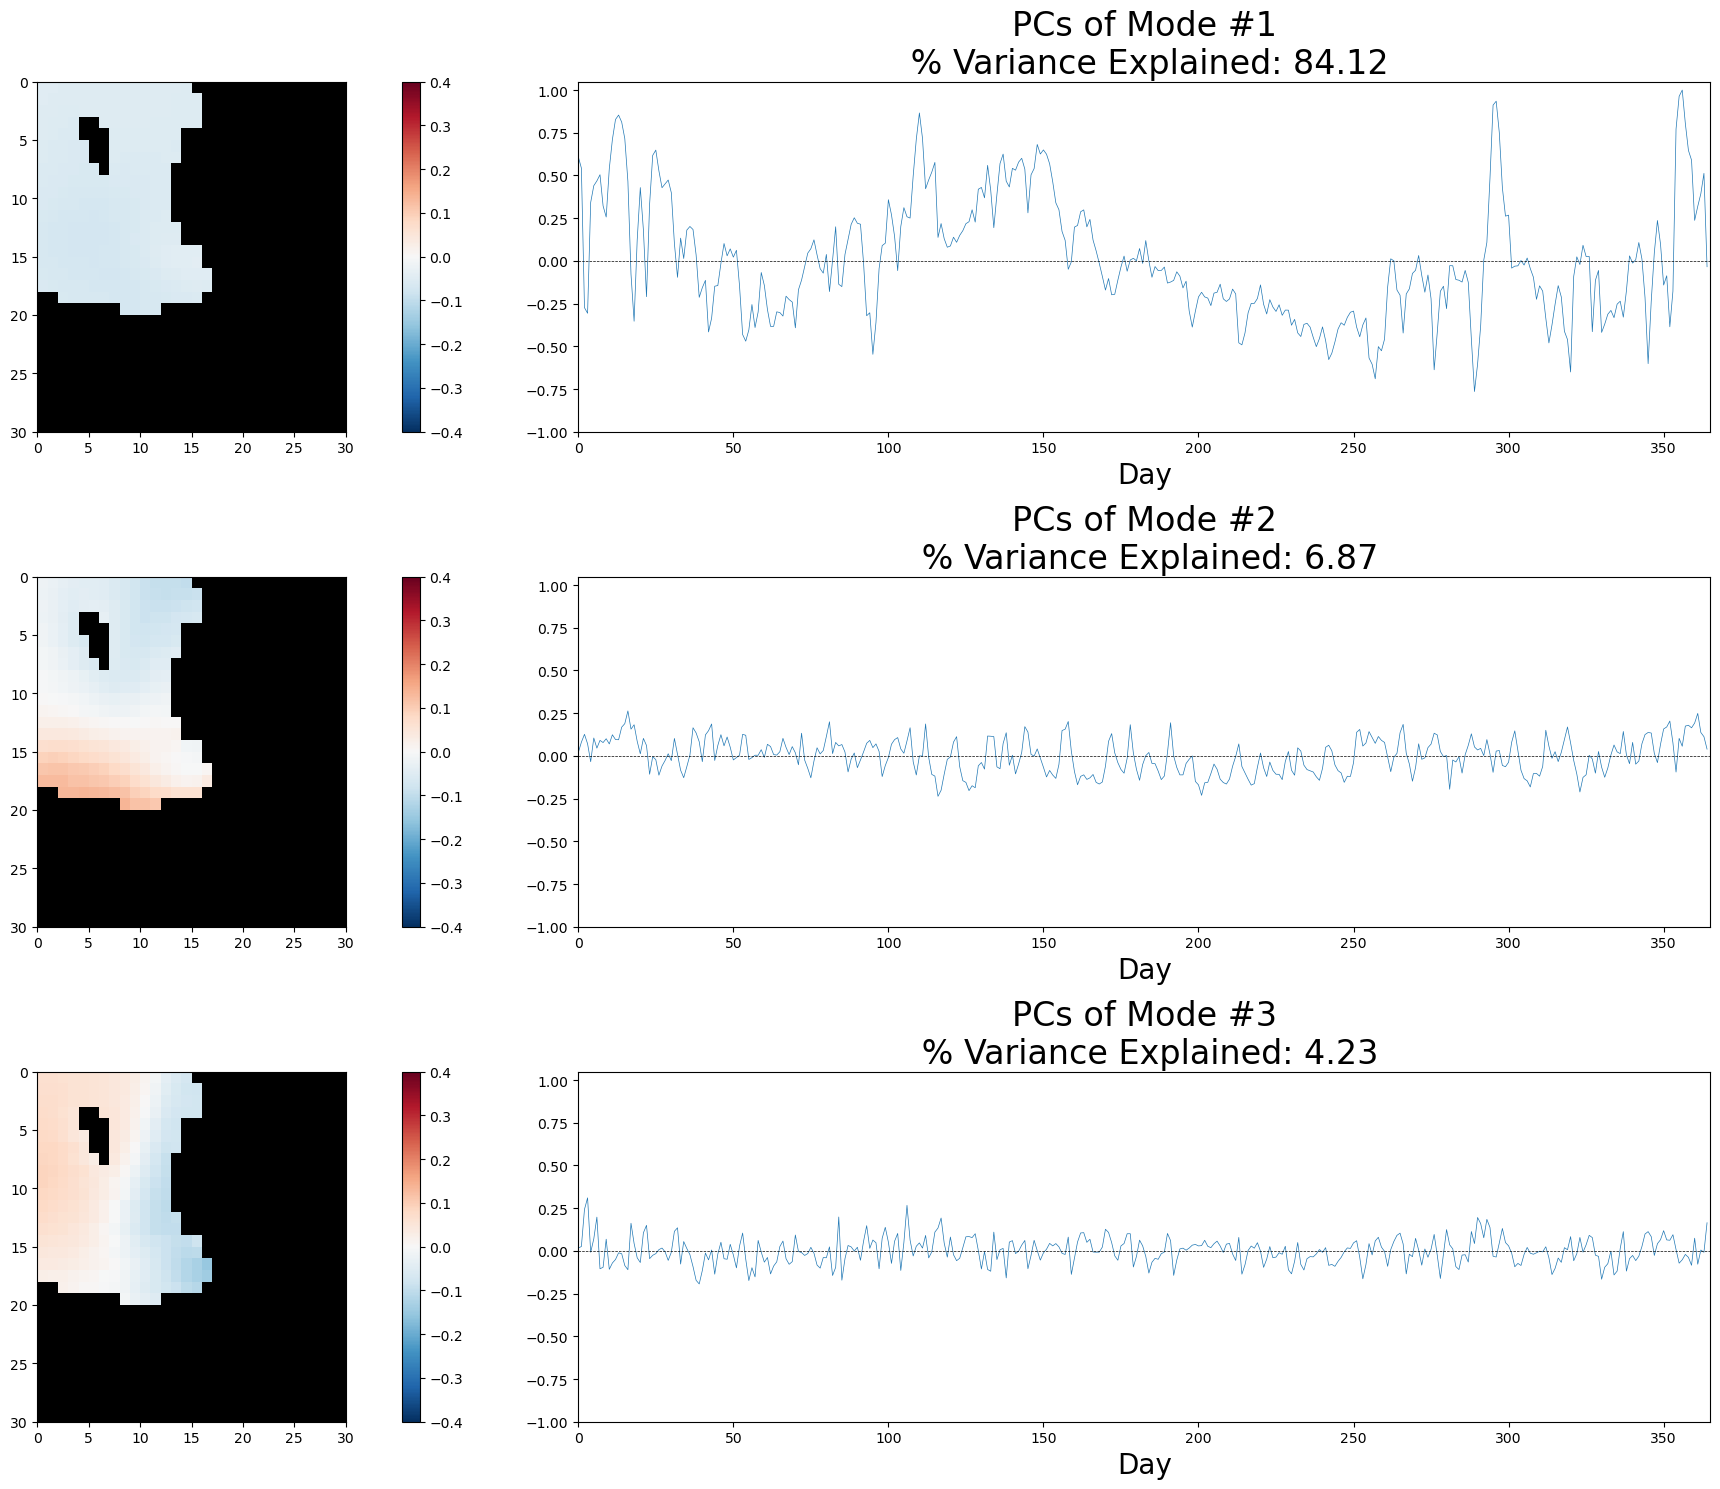

In [37]:
n = 3


np.sum(fracVar[:n]) # fraction of variance explained by this maNx modes  #TODO change this also to fn input, is the same n as below

bathymetry = xr.open_dataset('../../../../MEOPAR/grid/bathymetry_202108.nc')
land = np.array(np.isnan(bathymetry.Bathymetry).to_numpy(), dtype='float')
land[land == 0] = np.nan

#plot the first n modes and PCs -- choose a value of 'n' from the variance explained figure

fig2, ax2 = plt.subplots(n, 2, figsize=(23, 5*n))

for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    to_show = np.ma.masked_array(np.flipud(np.reshape(eigvecs[kk],(Ny,Nx))), mask=tmask)
    cb = ax2[kk,0].pcolormesh(np.flipud(np.reshape(eigvecs[kk],(Ny,Nx))), cmap='RdBu_r',vmin=-0.4,vmax=0.4)
    plt.colorbar(cb)
    cb2 = ax2[kk,0].pcolormesh(np.flipud(land[river_range[0]:river_range[1], river_range[2]:river_range[3]]), cmap='copper')
    ax2[kk,0].invert_yaxis()
    viz_tools.set_aspect(ax2[kk,0]);
    
    
    ax2[kk,1].plot(PCs[:,kk]/max_pc, linewidth = 0.5)
    ax2[kk,1].plot([0,len(PCs[:,kk])], [0,0],'k--',linewidth = 0.5)
    ax2[kk,1].set_title('PCs of Mode #' + str(kk+1) + "\n % Variance Explained: " + str(round(100*fracVar[kk],2)), fontsize = 24)
    ax2[kk,1].set_xlabel('Day', fontsize = 20)
    ax2[kk,1].set_ylim([-1,1.05])
    ax2[kk,1].set_xlim([0,len(PCs[:,kk])])
    
plt.tight_layout()

plt.savefig('PCs_n_' + river_call + '_' + str(n) + '.png')